来源：https://wiseodd.github.io/techblog/2017/12/23/annealed-importance-sampling/

### 重要性采样简介

$E_{x\sim p(x)}[f(x)]=\int p(x)f(x)dx = \int q(x)\frac{p(x)}{q(x)}f(x)dx=E_{x\sim q(x)}[\frac{p(x)}{q(x)}f(x)]\\= \frac{1}{N}\sum_{i=1,x_i\sim q(x)}^N \frac{p(x_i)}{q(x_i)}f(x_i)$

$p(x)$称为target distribution，$q(x)$称为proposal distribution。

重要性采样的算法大致如下：首先从q中采集N个样本，计算各样本的概率$q(x_i)$；然后将这N个样本带入p中得到$p(x_i)$。于是$w_i=\frac{p(x_i)}{q(x_i)}$就是每个$f(x_i)$的新权重，称为importance weight。

代码实现如下。假设我们想要估计Beta分布（target distribution）。从中取样很难，但我们可以计算其在某点的值。这里以均匀分布作为proposal distribution，这也意味着我们对target distribution没有任何认知。

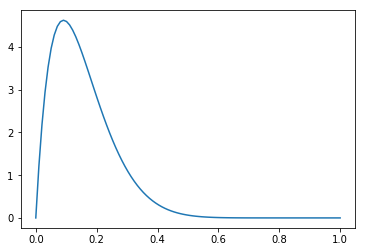

In [95]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

# beta分布的参数
a = 2
b = 11

x = np.linspace(0, 1, 100)
plt.plot(x, beta.pdf(x, a, b))

In [104]:
N = 10000

samples = np.random.rand(N,1)                    # 随机生成服从U(0,1)的N个样本

weights = 1                                      # q(x_i) = 1/(1-0) = 1（千万小心）
eval_pdf = beta.pdf(samples, a, b)               # x_i ~ Beta(a,b)，eval_pdf为p(x_i)
importance_w = eval_pdf / weights                # importance weight

w = importance_w / sum(importance_w)             # 对权重进行归一化操作

这些可以看出这些importance weight的分布形状与target distribution的分布形状一样。

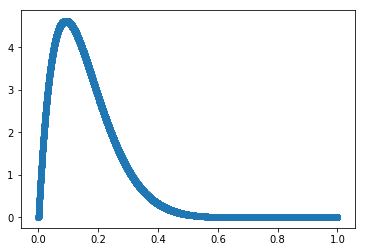

In [105]:
plt.scatter(samples, importance_w)

In [106]:
# 该Beta分布的均值约为0.1538  a/(a+b)

mean = beta.stats(a, b, moments='m')
print(mean)

0.15384615384615385


In [107]:
# 下面使用重要性采样来计算该均值 E(x)

is_mean = sum(samples * importance_w) / N
print(is_mean)

[0.15421186]


### AIS简介

假设由这样的分布：

$p(x)=\frac{1}{Z}f(x)$，$Z=\sum_{x} f(x)$

当维度很高时，求$Z$的这种求和操作时不可行的，因为可能有指数个项相加。

$E_{p(x)}[x]=\sum_{x}xp(x)$

若不知道$p(x)$，自然无法计算该期望。此时一种可取的方法是使用重要性采样，用另一个分布$q(x)$来近似$p(x)$。但确定合适的$q(x)$是比较困难的，这就是退火重要性采样（Annealed Importance Sampling，AIS）背后的动机。

### AIS的大致过程

### 代码实现

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt


def f_0(x):
    """ Target distribution -- 正比于 N(-5, 2) """
    return np.exp(-(x+5)**2/2/2)

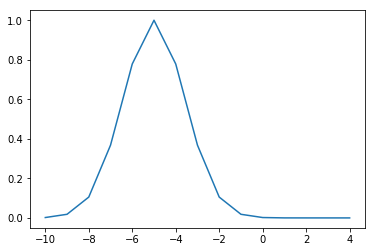

In [5]:
x = np.array(range(-10,5,1))

plt.plot(x, f_0(x))